# Performance of Scottish A&E Services
## Part 1 - Background & Introduction

Our dataset, sourced from publichhealthscotland.scot contains records of the time spent by patients in emergency care units across Scotland.

With this data, we set out with the goal of determining whether A&E complies with their 4-hour standard service across various months. This refers to A&E's compromise to treat 95% of their patients in under 4 hours (from their arrival at the clinic to their admission, discharge or transfer for treatment). 

Moreover, we would like to identify any potential trends in compliance throughout the year, as affected by seasonal differences or world events (ie. COVID-19 Pandemic). Finally, we will determine whether certain treatment locations change more than others over time.

For each of our points of investigation, we will explore a relevant null hypothesis which we will attempt to disprove through inferential and ML analytic methods.

## Part 2 - Understanding the Data

We begin by loading and exploring the different features of the data by using pandas and the seaborn package for visualization. 

We look to use our findings in this section to inform us on the transformations and/or processes we must apply in order to prepare our data for our analysis.

In [4]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import geopandas
# Automatic Trend Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Different statistical tests
from scipy.stats import ttest_rel  # Paired t-test
from statsmodels.tsa.stattools import adfuller  # Stationarity Test
from scipy.stats import kruskal  # Seasonality Test
from statsmodels.formula.api import ols  # Regression OLS model


# Set matplotlib style to seaborn white grid
plt.style.use('seaborn-whitegrid')

In [5]:
# We start by loading in the csv file from the datasets folder
data = pd.read_csv('datasets/ae_activity_waiting_times_feb2022-data.csv',)

In [6]:
# We start by simply visualizing the data
data.head()

,Data_Month_Date,Country,HB_Treatment_Description,Treatment_Location_Code,Treatment_Location_Name,ED_MIU,Number_Of_Attendances_agg,Number_of_Attendances_Epi,Number_Meeting_Target_agg,Number_Meeting_Target_epi,Discharge_destination_admission_to_same,Discharge_destination_other_spec,Discharge_destination_residence,Discharge_destination_transfer,Discharge_destination_unknown,Attendance_greater_8hrs,Attendances_greater_12hrs
0,Jul-07,NHS Scotland,NHS Ayrshire & Arran,A101H,Arran War Memorial Hospital,MIU/Other,252,NaN,252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jul-07,NHS Scotland,NHS Ayrshire & Arran,A111H,University Hospital Crosshouse - ED,ED,5414,5414.0,5290,5290.0,1985.0,11.0,3374.0,44.0,0.0,26.0,24.0
2,Jul-07,NHS Scotland,NHS Ayrshire & Arran,A207H,Davidson Cottage Hospital,MIU/Other,92,NaN,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Jul-07,NHS Scotland,NHS Ayrshire & Arran,A210H,University Hospital Ayr - ED,ED,3530,3530.0,3355,3355.0,106.0,0.0,3369.0,8.0,47.0,3.0,1.0
4,Jul-07,NHS Scotland,NHS Borders,B103H,Knoll Community Hospital,MIU/Other,20,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Let's see what the end of the dataset looks like
data.tail()

,Data_Month_Date,Country,HB_Treatment_Description,Treatment_Location_Code,Treatment_Location_Name,ED_MIU,Number_Of_Attendances_agg,Number_of_Attendances_Epi,Number_Meeting_Target_agg,Number_Meeting_Target_epi,Discharge_destination_admission_to_same,Discharge_destination_other_spec,Discharge_destination_residence,Discharge_destination_transfer,Discharge_destination_unknown,Attendance_greater_8hrs,Attendances_greater_12hrs
15466,Dec-21,NHS Scotland,NHS Tayside,T304H,Arbroath Infirmary,MIU/Other,473,473.0,473,473.0,0.0,0.0,422.0,48.0,3.0,0.0,0.0
15467,Dec-21,NHS Scotland,NHS Tayside,T319H,Whitehills Health And Community Care Centre,MIU/Other,227,227.0,227,227.0,0.0,0.0,209.0,18.0,0.0,0.0,0.0
15468,Dec-21,NHS Scotland,NHS Western Isles,W106H,St Brendan's Hospital,MIU/Other,41,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15469,Dec-21,NHS Scotland,NHS Western Isles,W107H,Western Isles Hospital - ED,ED,325,325.0,313,313.0,94.0,1.0,227.0,2.0,1.0,1.0,0.0
15470,Dec-21,NHS Scotland,NHS Western Isles,W108H,Uist & Barra Hospital,MIU/Other,69,69.0,69,69.0,6.0,0.0,63.0,0.0,0.0,0.0,0.0


In [8]:
# We have over 15000 entries, so our dataset is quite large -- higher confidence?
data.shape

(15471, 17)

In [9]:
# Let's identify the basic univariate statistics for each of our columns
data.describe()

,Number_Of_Attendances_agg,Number_of_Attendances_Epi,Number_Meeting_Target_agg,Number_Meeting_Target_epi,Discharge_destination_admission_to_same,Discharge_destination_other_spec,Discharge_destination_residence,Discharge_destination_transfer,Discharge_destination_unknown,Attendance_greater_8hrs,Attendances_greater_12hrs
count,15471.000000,7934.000000,15471.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000
mean,1488.786439,2721.348122,1387.596277,2525.028107,691.075372,4.278170,1839.021175,64.632720,122.340686,21.695866,4.916940
std,2092.080760,2316.189953,1902.878363,2086.647656,753.821751,8.125614,1531.270193,78.798994,450.112019,69.283360,24.734333
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,91.000000,621.000000,91.000000,608.000000,5.000000,0.000000,450.000000,6.000000,1.000000,0.000000,0.000000
50%,367.000000,2169.500000,363.000000,2067.500000,428.000000,1.000000,1537.500000,33.000000,14.000000,1.000000,0.000000
75%,2275.000000,4491.000000,2175.000000,4135.000000,1210.000000,6.000000,3011.000000,97.000000,79.750000,11.000000,0.000000
max,11579.000000,11579.000000,10130.000000,10130.000000,3687.000000,254.000000,7846.000000,563.000000,6458.000000,1451.000000,666.000000


In [10]:
data.nunique()

Data_Month_Date                             174
Country                                       1
HB_Treatment_Description                     14
Treatment_Location_Code                     102
Treatment_Location_Name                     109
ED_MIU                                        2
Number_Of_Attendances_agg                  4544
Number_of_Attendances_Epi                  4422
Number_Meeting_Target_agg                  4443
Number_Meeting_Target_epi                  4316
Discharge_destination_admission_to_same    2171
Discharge_destination_other_spec             57
Discharge_destination_residence            3658
Discharge_destination_transfer              394
Discharge_destination_unknown               710
Attendance_greater_8hrs                     341
Attendances_greater_12hrs                   158
dtype: int64

We will now check to see how many null values there are per column

In [11]:
data.isnull().sum()

Data_Month_Date                               0
Country                                       0
HB_Treatment_Description                      0
Treatment_Location_Code                       0
Treatment_Location_Name                       0
ED_MIU                                        0
Number_Of_Attendances_agg                     0
Number_of_Attendances_Epi                  7537
Number_Meeting_Target_agg                     0
Number_Meeting_Target_epi                  7537
Discharge_destination_admission_to_same    7537
Discharge_destination_other_spec           7537
Discharge_destination_residence            7537
Discharge_destination_transfer             7537
Discharge_destination_unknown              7537
Attendance_greater_8hrs                    7537
Attendances_greater_12hrs                  7537
dtype: int64

As we can see from the data, the EPI category corresponding to the Hospital Episode Statistic (a database used to calculate the costs for each patient) contains NaN values for a considerable amount of rows in the NUmber of Attendances and Number Meeting Target columns. 

In order to guarantee that the two statistics are comparable, we will check to see if their values match for each of the Treatment Locations.

In [12]:
# Check for equality between non-NaN values in Number_Of_Attendances_agg and Number_of_Attendances_epi
nonNullAttendance = data[data['Number_of_Attendances_Epi'].notna()]
print((nonNullAttendance['Number_Of_Attendances_agg'] != nonNullAttendance['Number_of_Attendances_Epi']).sum())


# Check for equality between non-NaN values in Number_Meeting_Target_agg and Number_Meeting_Target_epi
nonNullMeeting = data[data['Number_Meeting_Target_epi'].notna()]
print((nonNullMeeting["Number_Meeting_Target_agg"] != nonNullMeeting["Number_Meeting_Target_epi"]).sum())

nonMatching = nonNullAttendance[nonNullAttendance['Number_Of_Attendances_agg'] != nonNullAttendance['Number_of_Attendances_Epi']]
nonMatching[['Data_Month_Date', 'Treatment_Location_Name', 'Number_Of_Attendances_agg', 'Number_of_Attendances_Epi', 'Number_Meeting_Target_agg', 'Number_Meeting_Target_epi']]

2
2


,Data_Month_Date,Treatment_Location_Name,Number_Of_Attendances_agg,Number_of_Attendances_Epi,Number_Meeting_Target_agg,Number_Meeting_Target_epi
14762,Jan-21,Edington Cottage Hospital,40,1.0,40,1.0
15208,Aug-21,Edington Cottage Hospital,104,1.0,104,1.0


We see that there is only one treatment location (Edington Cottage Hospital) for which the values of both statistics do not match. In fact, the reported number of attendances in the EPI database seem to be abnormally and completely different from aggregate values, suggesting some glitch or problem in the system. 

We therefore decide to use the aggregate measure for our analysis.

In [13]:
# We see there are many more unique date values than we expect (one per month would give 12 unique values)
# Therefore, we will have to determine a way of aggregating these when cleaning the data
data['Data_Month_Date'].unique()

array(['Jul-07', 'Aug-07', 'Sep-07', 'Oct-07', 'Nov-07', 'Dec-07',
       'Jan-08', 'Feb-08', 'Mar-08', 'Apr-08', 'May-08', 'Jun-08',
       'Jul-08', 'Aug-08', 'Sep-08', 'Oct-08', 'Nov-08', 'Dec-08',
       'Jan-09', 'Feb-09', 'Mar-09', 'Apr-09', 'May-09', 'Jun-09',
       'Jul-09', 'Aug-09', 'Sep-09', 'Oct-09', 'Nov-09', 'Dec-09',
       'Jan-10', 'Feb-10', 'Mar-10', 'Apr-10', 'May-10', 'Jun-10',
       'Jul-10', 'Aug-10', 'Sep-10', 'Oct-10', 'Nov-10', 'Dec-10',
       'Jan-11', 'Feb-11', 'Mar-11', 'Apr-11', 'May-11', 'Jun-11',
       'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11',
       'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12', 'May-12', 'Jun-12',
       'Jul-12', 'Aug-12', 'Sep-12', 'Oct-12', 'Nov-12', 'Dec-12',
       'Jan-13', 'Feb-13', 'Mar-13', 'Apr-13', 'May-13', 'Jun-13',
       'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13',
       'Jan-14', 'Feb-14', 'Mar-14', 'Apr-14', 'May-14', 'Jun-14',
       'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-

Moreover, we see the Country column does not give us any information on the data as it only indicates this is Scottish data. We will eventually drop this column from our final dataset.

## Part 3 - Cleaning + Wrangling the Data

We hence proceed to clean the data we have identified in preparation for our analysis

In [14]:
# We create a new year column for our dataframe
data.insert(0, "Year", data['Data_Month_Date'].apply(lambda val: int("20" + val.split('-')[1])))
data.insert(1, "Month", data['Data_Month_Date'].apply(lambda val: val.split('-')[0]))

# We can now drop the unnecessary columns from the dataframe
data = data.drop(["Country"], axis=1)

# Now that we have created the 2 separate column, we can convert the original into datetime
# We define a custom date parser to parse the date column
dateparse = lambda x: datetime.strptime(x, '%b-%y')
data['Data_Month_Date'] = pd.to_datetime(data['Data_Month_Date'], format='%b-%y')

# We create a dummy pandemic binary variable to make plotting easier
data['pandemic'] = data['Data_Month_Date'].apply(lambda dat: 0 if dat < datetime(2020, 3, 1) else 1)

# We inspect the new dataframe
data

,Year,Month,Data_Month_Date,HB_Treatment_Description,Treatment_Location_Code,Treatment_Location_Name,ED_MIU,Number_Of_Attendances_agg,Number_of_Attendances_Epi,Number_Meeting_Target_agg,Number_Meeting_Target_epi,Discharge_destination_admission_to_same,Discharge_destination_other_spec,Discharge_destination_residence,Discharge_destination_transfer,Discharge_destination_unknown,Attendance_greater_8hrs,Attendances_greater_12hrs,pandemic
0,2007,Jul,2007-07-01,NHS Ayrshire & Arran,A101H,Arran War Memorial Hospital,MIU/Other,252,NaN,252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2007,Jul,2007-07-01,NHS Ayrshire & Arran,A111H,University Hospital Crosshouse - ED,ED,5414,5414.0,5290,5290.0,1985.0,11.0,3374.0,44.0,0.0,26.0,24.0,0
2,2007,Jul,2007-07-01,NHS Ayrshire & Arran,A207H,Davidson Cottage Hospital,MIU/Other,92,NaN,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2007,Jul,2007-07-01,NHS Ayrshire & Arran,A210H,University Hospital Ayr - ED,ED,3530,3530.0,3355,3355.0,106.0,0.0,3369.0,8.0,47.0,3.0,1.0,0
4,2007,Jul,2007-07-01,NHS Borders,B103H,Knoll Community Hospital,MIU/Other,20,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15466,2021,Dec,2021-12-01,NHS Tayside,T304H,Arbroath Infirmary,MIU/Other,473,473.0,473,473.0,0.0,0.0,422.0,48.0,3.0,0.0,0.0,1
15467,2021,Dec,2021-12-01,NHS Tayside,T319H,Whitehills Health And Community Care Centre,MIU/Other,227,227.0,227,227.0,0.0,0.0,209.0,18.0,0.0,0.0,0.0,1
15468,2021,Dec,2021-12-01,NHS Western Isles,W106H,St Brendan's Hospital,MIU/Other,41,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
15469,2021,Dec,2021-12-01,NHS Western Isles,W107H,Western Isles Hospital - ED,ED,325,325.0,313,313.0,94.0,1.0,227.0,2.0,1.0,1.0,0.0,1


## Part 4 - Visualizing the Monthly Trend

In order to visualize the general trend in compliance over time, we will use a line plot going from July 2007 until December 2021. We will plot aggregate number of attendances meeting the target.

We will use Seaborn to represent the minimum and maximum values for each month on top of the main line which will show the mean total number of attendances dispatched in under 4 hours.

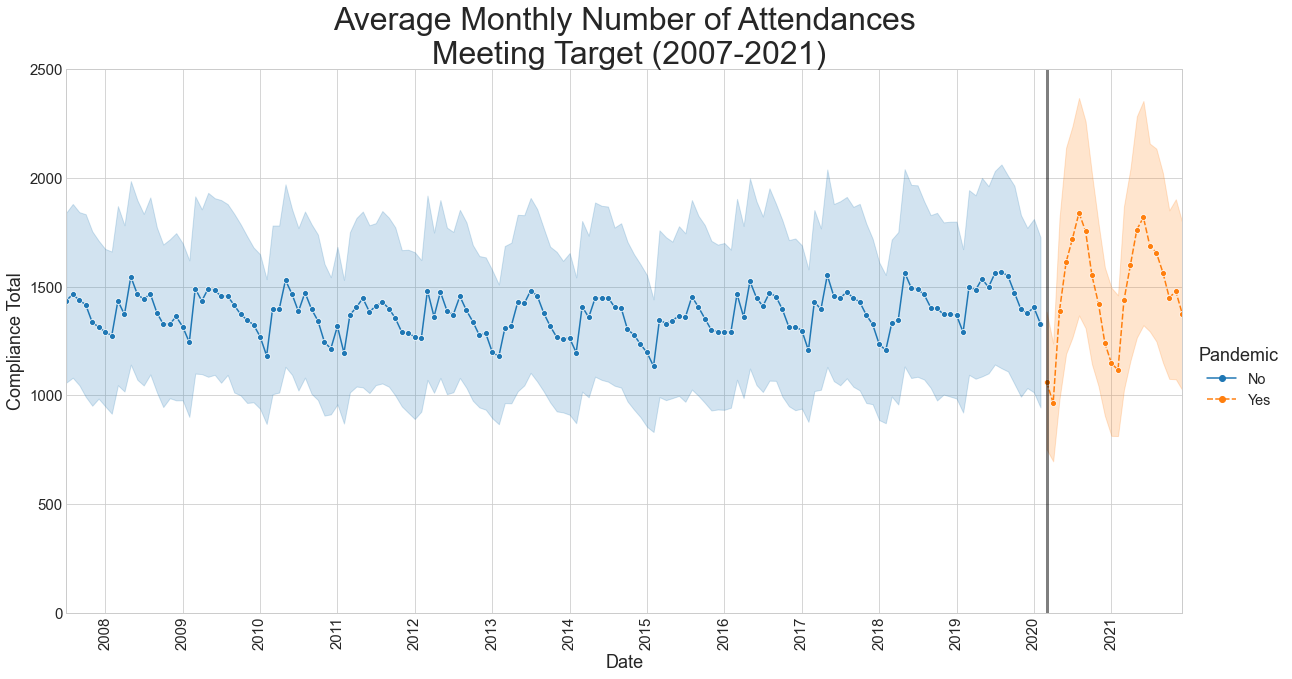

In [15]:
# Trend of aggregate data over time

# We define year and month locators as well as custom year format for graph
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

# We create our figure and axes
fig, axes = plt.subplots(figsize=(20, 10))

# We use seaborn package to create line plot and manually set x and y axis labels
graph = sns.lineplot(data=data, x="Data_Month_Date", y='Number_Meeting_Target_agg', markers=['o', 'o'], style='pandemic', hue='pandemic')
graph.set_title("Average Monthly Number of Attendances\n Meeting Target (2007-2021)", fontsize=32)
graph.set_xlabel("Date", fontsize=18)
graph.set_ylabel("Compliance Total", fontsize=18)

# We set the major and minor tick locators to graph and add formatted labels
axes.xaxis.set_major_locator(years)
axes.xaxis.set_major_formatter(years_fmt)
axes.xaxis.set_minor_locator(months)

# We rotate the labels vertically for better readability and show the plot
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=15)

# We fix the x-axis limits
plt.xlim(datetime(2007, 7, 1), datetime(2021, 12, 1))

# We add pandemic divider
plt.axvline(datetime(2020, 3, 1), linewidth=3, color='black', alpha=0.5)

# Adjust the legend
plt.legend(title='Pandemic', bbox_to_anchor=(1.01, 0.5), loc=2, borderaxespad=0., fontsize='x-large', title_fontsize='18')

for t, l in zip(graph.get_legend().texts, ['No', 'Yes']):
    t.set_text(l)

# Fix y axis limits to avoid distortion
plt.ylim(0, 2500)

plt.savefig("monthly.png")

plt.show()

## Part 5 - Comparing Different Health Boards

In order to see the effect the pandemic had on the 14 different health boards across Scotland, we compared the average percentage of the health boards meeting their targets from before the pandemic (July 2007 - February 2020) and during (March 2020 - December 2021).

To show the data geographically, a map of the health boards in Scotland was taken from the government website<sup>[1]</sup> and the health board names were changed to match those in the initial dataset

[1] - https://data.gov.uk/dataset/27d0fe5f-79bb-4116-aec9-a8e565ff756a/nhs-health-boards-scotland

In [16]:
health_boards = geopandas.read_file("datasets/SG_NHS_HealthBoards_2019/SG_NHS_HealthBoards_2019.shp")

health_boards["HBName"] = health_boards["HBName"].str.replace(" and", " &")
health_boards["HB_Treatment_Description"] = "NHS " + health_boards["HBName"]

health_boards = health_boards.drop(columns="HBName")

health_boards

,HBCode,Shape_Leng,Shape_Area,geometry,HB_Treatment_Description
0,S08000015,6.797823e+05,3.408802e+09,"MULTIPOLYGON (((201916.200 600444.404, 201918....",NHS Ayrshire & Arran
1,S08000016,5.254067e+05,4.742685e+09,"POLYGON ((345325.903 579663.303, 345325.104 57...",NHS Borders
2,S08000017,8.303012e+05,6.676315e+09,"MULTIPOLYGON (((266004.400 543544.601, 266010....",NHS Dumfries & Galloway
3,S08000019,4.305683e+05,2.733659e+09,"POLYGON ((256533.002 740502.003, 256501.497 74...",NHS Forth Valley
4,S08000020,8.028443e+05,8.800885e+09,"MULTIPOLYGON (((383521.198 771234.696, 383524....",NHS Grampian
5,S08000022,8.486538e+06,3.363704e+10,"MULTIPOLYGON (((173254.001 604986.004, 173258....",NHS Highland
6,S08000024,3.789231e+05,1.760804e+09,"MULTIPOLYGON (((313586.104 679560.597, 313614....",NHS Lothian
7,S08000025,1.589228e+06,1.086211e+09,"MULTIPOLYGON (((347378.503 976721.996, 347387....",NHS Orkney
8,S08000026,2.211514e+06,1.656618e+09,"MULTIPOLYGON (((419927.604 1069152.398, 419927...",NHS Shetland
9,S08000028,3.723205e+06,3.268473e+09,"MULTIPOLYGON (((55528.504 780719.001, 55556.50...",NHS Western Isles


In [17]:
# Calculating the percentage of each hosptial for each month meeting the four hour target
data["Percentage_Meeting_Target_agg"] = (data["Number_Meeting_Target_agg"] / data["Number_Of_Attendances_agg"]) * 100
data

,Year,Month,Data_Month_Date,HB_Treatment_Description,Treatment_Location_Code,Treatment_Location_Name,ED_MIU,Number_Of_Attendances_agg,Number_of_Attendances_Epi,Number_Meeting_Target_agg,Number_Meeting_Target_epi,Discharge_destination_admission_to_same,Discharge_destination_other_spec,Discharge_destination_residence,Discharge_destination_transfer,Discharge_destination_unknown,Attendance_greater_8hrs,Attendances_greater_12hrs,pandemic,Percentage_Meeting_Target_agg
0,2007,Jul,2007-07-01,NHS Ayrshire & Arran,A101H,Arran War Memorial Hospital,MIU/Other,252,NaN,252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100.000000
1,2007,Jul,2007-07-01,NHS Ayrshire & Arran,A111H,University Hospital Crosshouse - ED,ED,5414,5414.0,5290,5290.0,1985.0,11.0,3374.0,44.0,0.0,26.0,24.0,0,97.709642
2,2007,Jul,2007-07-01,NHS Ayrshire & Arran,A207H,Davidson Cottage Hospital,MIU/Other,92,NaN,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100.000000
3,2007,Jul,2007-07-01,NHS Ayrshire & Arran,A210H,University Hospital Ayr - ED,ED,3530,3530.0,3355,3355.0,106.0,0.0,3369.0,8.0,47.0,3.0,1.0,0,95.042493
4,2007,Jul,2007-07-01,NHS Borders,B103H,Knoll Community Hospital,MIU/Other,20,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15466,2021,Dec,2021-12-01,NHS Tayside,T304H,Arbroath Infirmary,MIU/Other,473,473.0,473,473.0,0.0,0.0,422.0,48.0,3.0,0.0,0.0,1,100.000000
15467,2021,Dec,2021-12-01,NHS Tayside,T319H,Whitehills Health And Community Care Centre,MIU/Other,227,227.0,227,227.0,0.0,0.0,209.0,18.0,0.0,0.0,0.0,1,100.000000
15468,2021,Dec,2021-12-01,NHS Western Isles,W106H,St Brendan's Hospital,MIU/Other,41,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.000000
15469,2021,Dec,2021-12-01,NHS Western Isles,W107H,Western Isles Hospital - ED,ED,325,325.0,313,313.0,94.0,1.0,227.0,2.0,1.0,1.0,0.0,1,96.307692


In [18]:
# Selecting only prepandemic rows
prepandemic = data[(data["Year"] < 2020) | ((data["Year"] == 2020) & ((data["Month"].str.contains("Jan")) | (data["Month"].str.contains("Feb"))))]

# Grouping by the NHS Health Boards and taking the average percentage of each meeting the target
grouped_pp = prepandemic.groupby("HB_Treatment_Description")["Percentage_Meeting_Target_agg"].mean()

# Summing the number of attendances and how many were under the four hours
grouped_pp2 = prepandemic.groupby("HB_Treatment_Description")["Number_Of_Attendances_agg", "Number_Meeting_Target_agg"].sum()

# Calculating the total percentage
grouped_pp2["Percentage_Meeting_Target_agg"] = grouped_pp2["Number_Meeting_Target_agg"] * 100 / grouped_pp2["Number_Of_Attendances_agg"]

# Repeating for pandemic data
pandemic = data[(data["Year"] > 2020) | ((data["Year"] == 2020) & ~((data["Month"].str.contains("Jan")) | (data["Month"].str.contains("Feb"))))]

grouped_pan = pandemic.groupby("HB_Treatment_Description")["Percentage_Meeting_Target_agg"].mean()

grouped_pan2 = pandemic.groupby("HB_Treatment_Description")["Number_Of_Attendances_agg", "Number_Meeting_Target_agg"].sum()

grouped_pan2["Percentage_Meeting_Target_agg"] = grouped_pan2["Number_Meeting_Target_agg"] * 100 / grouped_pan2["Number_Of_Attendances_agg"]

grouped_pp2

/var/folders/ms/nm8qh3t50b1dpfl42qcf4jzw0000gn/T/ipykernel_78431/2493585491.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_pp2 = prepandemic.groupby("HB_Treatment_Description")["Number_Of_Attendances_agg", "Number_Meeting_Target_agg"].sum()
/var/folders/ms/nm8qh3t50b1dpfl42qcf4jzw0000gn/T/ipykernel_78431/2493585491.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_pan2 = pandemic.groupby("HB_Treatment_Description")["Number_Of_Attendances_agg", "Number_Meeting_Target_agg"].sum()


,Number_Of_Attendances_agg,Number_Meeting_Target_agg,Percentage_Meeting_Target_agg
HB_Treatment_Description,,,
NHS Ayrshire & Arran,1486400,1392735,93.698533
NHS Borders,359542,344202,95.733461
NHS Dumfries & Galloway,613958,583769,95.082888
NHS Fife,1129238,1074551,95.157177
NHS Forth Valley,979070,910011,92.946470
NHS Grampian,1789907,1718706,96.022084
NHS Greater Glasgow & Clyde,5663384,5252481,92.744568
NHS Highland,1250927,1218395,97.399369
NHS Lanarkshire,2490684,2309061,92.707907


Text(0.5, 0.98, 'Average Percentage of Attendees Seen Within 4 Hours')

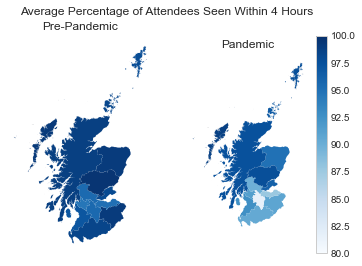

In [19]:
# Merge the dataframes with the map dataset
prepandemic_targets = health_boards.merge(grouped_pp, on = "HB_Treatment_Description")

pandemic_targets = health_boards.merge(grouped_pan, on = "HB_Treatment_Description")

fig, (ax1, ax2) = plt.subplots(1, 2)

# Remove the axes for better readability
ax1.set_axis_off()
ax2.set_axis_off()

# Plot both maps with the same minimum value for better comparison
prepandemic_targets.plot(column="Percentage_Meeting_Target_agg", ax=ax1, vmin = 80, vmax = 100, cmap='Blues', label="Average Percentage of Pre-Pandemic Attendees Seen in 4 Hours")
ax1.set_title("Pre-Pandemic")

pandemic_targets.plot(column="Percentage_Meeting_Target_agg", ax=ax2, vmin = 80, vmax = 100, legend=True, cmap='Blues')
ax2.set_title("Pandemic")

fig.suptitle("Average Percentage of Attendees Seen Within 4 Hours")

Text(0.5, 0.98, 'Percentage of Attendees Seen Within 4 Hours')

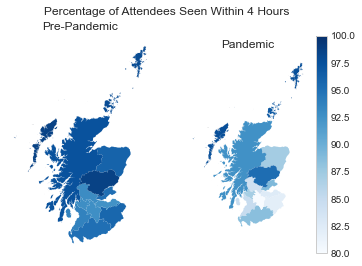

In [20]:
prepandemic_targets = health_boards.merge(grouped_pp2, on = "HB_Treatment_Description")

pandemic_targets = health_boards.merge(grouped_pan2, on = "HB_Treatment_Description")

fig, (ax1, ax2) = plt.subplots(1, 2)

# Remove the axes for better readability
ax1.set_axis_off()
ax2.set_axis_off()

# Plot both maps with the same minimum value for better comparison
prepandemic_targets.plot(column="Percentage_Meeting_Target_agg", ax=ax1, vmin = 80, vmax = 100, cmap='Blues')
ax1.set_title("Pre-Pandemic")

pandemic_targets.plot(column="Percentage_Meeting_Target_agg", ax=ax2, vmin = 80, vmax = 100, legend = True, cmap='Blues')
ax2.set_title("Pandemic")

fig.suptitle("Percentage of Attendees Seen Within 4 Hours")

From the plots it can be seen that while hospitals in areas like the Highlands, Western Isles, Orkney and Shetland were not that affected by the pandemic, the Central Belt was, especially Lanarkshire, Ayrshire and Arran, Lothian, and the Borders. This may be due to the population density of these areas, and would be worth exploring further.

In [21]:
# Worth running a quick linear regression between population density and 
# percentage change in each region?

## Part 6 - Visualizing Seasonal Distribution of Number of Attendances

Apart from the evident drop in the percentage meeting the 4 hour target before and after the pandemic, the original linear plot showing the monthly trend in the data also revealed another interesting pattern which we would like to explore. The plot seems to suggest that seasons might have a significant effect on the number of attendance meeting the target. As we can see from above, the recurring trend seems to be that percentage of attendances meeting the target increases sharply at around the beginning of each year and then trails off in the subsequent months. 

To emphasize this effect, we will attempt to visualize it using a box-and-whisker plot.

In [22]:
# We define a simple transformation function that returns the appropriate season for a given month
def findSeason(month):
    if month in ['Mar', 'Apr', 'May']:
        return 'Spring'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Summer'
    elif month in ['Sep', 'Oct', 'Nov']:
        return 'Autumn'
    else:
        return 'Winter'

# We start by generating a new variable Season from the month column in our dataset
seasonCol = data['Month'].apply(findSeason)
data.insert(3, column='Season', value=seasonCol)

# Visualize the dataset with the added column
data

,Year,Month,Data_Month_Date,Season,HB_Treatment_Description,Treatment_Location_Code,Treatment_Location_Name,ED_MIU,Number_Of_Attendances_agg,Number_of_Attendances_Epi,...,Number_Meeting_Target_epi,Discharge_destination_admission_to_same,Discharge_destination_other_spec,Discharge_destination_residence,Discharge_destination_transfer,Discharge_destination_unknown,Attendance_greater_8hrs,Attendances_greater_12hrs,pandemic,Percentage_Meeting_Target_agg
0,2007,Jul,2007-07-01,Summer,NHS Ayrshire & Arran,A101H,Arran War Memorial Hospital,MIU/Other,252,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100.000000
1,2007,Jul,2007-07-01,Summer,NHS Ayrshire & Arran,A111H,University Hospital Crosshouse - ED,ED,5414,5414.0,...,5290.0,1985.0,11.0,3374.0,44.0,0.0,26.0,24.0,0,97.709642
2,2007,Jul,2007-07-01,Summer,NHS Ayrshire & Arran,A207H,Davidson Cottage Hospital,MIU/Other,92,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100.000000
3,2007,Jul,2007-07-01,Summer,NHS Ayrshire & Arran,A210H,University Hospital Ayr - ED,ED,3530,3530.0,...,3355.0,106.0,0.0,3369.0,8.0,47.0,3.0,1.0,0,95.042493
4,2007,Jul,2007-07-01,Summer,NHS Borders,B103H,Knoll Community Hospital,MIU/Other,20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15466,2021,Dec,2021-12-01,Winter,NHS Tayside,T304H,Arbroath Infirmary,MIU/Other,473,473.0,...,473.0,0.0,0.0,422.0,48.0,3.0,0.0,0.0,1,100.000000
15467,2021,Dec,2021-12-01,Winter,NHS Tayside,T319H,Whitehills Health And Community Care Centre,MIU/Other,227,227.0,...,227.0,0.0,0.0,209.0,18.0,0.0,0.0,0.0,1,100.000000
15468,2021,Dec,2021-12-01,Winter,NHS Western Isles,W106H,St Brendan's Hospital,MIU/Other,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.000000
15469,2021,Dec,2021-12-01,Winter,NHS Western Isles,W107H,Western Isles Hospital - ED,ED,325,325.0,...,313.0,94.0,1.0,227.0,2.0,1.0,1.0,0.0,1,96.307692


Seasonal boundaries are taken from UK MET.

[2] - https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjUi4_SvNr2AhUPZcAKHSpUAWYQFnoECBUQAw&url=https%3A%2F%2Fwww.metoffice.gov.uk%2Fweather%2Flearn-about%2Fweather%2Fseasons%2Fspring%2Fwhen-does-spring-start&usg=AOvVaw1vnauQaxk3hThuGmlNoOw0

With our newly added column, we can now create a plot to inspect the distribution of the number of attendances in each season.

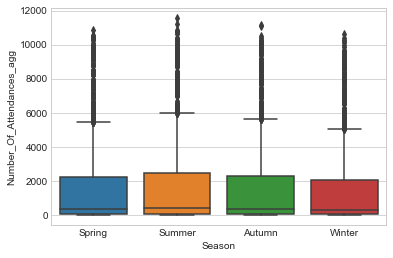

In [23]:
# We will use the seaborn boxplot function to visualize the distributions
ax = sns.boxplot(x='Season', y='Number_Of_Attendances_agg', data=data, order=['Spring', 'Summer', 'Autumn', 'Winter'])

The distribution for our number of attendances seems to be quite right-skewed. In the interest of exploring the skewness of our different variables, we will inspect their kurtosis values.

In [24]:
# Report kurtosis values for our different variables
data.kurt()

/var/folders/ms/nm8qh3t50b1dpfl42qcf4jzw0000gn/T/ipykernel_78431/184175691.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.kurt()


Year                                        -1.139006
Number_Of_Attendances_agg                    2.192515
Number_of_Attendances_Epi                    0.121123
Number_Meeting_Target_agg                    1.831280
Number_Meeting_Target_epi                   -0.073299
Discharge_destination_admission_to_same      0.378101
Discharge_destination_other_spec           209.614073
Discharge_destination_residence              0.237653
Discharge_destination_transfer               4.391643
Discharge_destination_unknown               81.460084
Attendance_greater_8hrs                     99.130239
Attendances_greater_12hrs                  227.456374
pandemic                                     6.121405
Percentage_Meeting_Target_agg               15.914757
dtype: float64

We see that Number_Of_Attendances_agg is very skewed, so we will attempt to apply a log transformation to help make the distribution closer to a normal distribution.

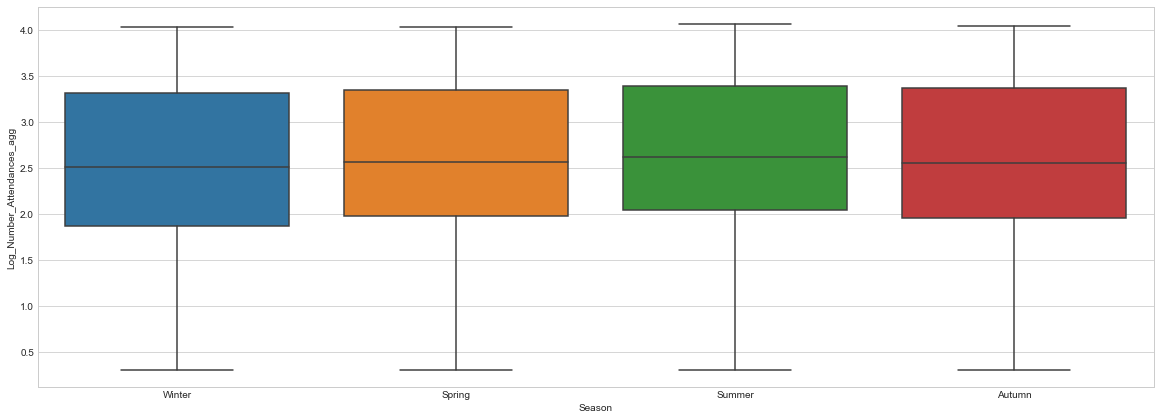

In [25]:
# Apply log10 transformation to Number_Of_Attendances_agg 
data['Log_Number_Attendances_agg'] = np.log10(data['Number_Of_Attendances_agg'] + 1)
# We will apply a similar transformation to Number_Meeting_Attendance_agg so we can also visualize this
data['Log_Meeting_Target_agg'] = np.log10(data['Number_Meeting_Target_agg'] + 1)

# We create our figure and axes
fig, axes = plt.subplots(figsize=(20, 7))

# We create the box plot
ax = sns.boxplot(x='Season', y='Log_Number_Attendances_agg', data=data, order=['Winter', 'Spring', 'Summer', 'Autumn'])

plt.show()

Even though it is evident that there are differences in the 4 distributions, it is not very clear what these differences are and comparing the four categories is hard, especially at first glance. 

In order to address this, we revise this plot and decide to use a violin plot instead which makes some features of the distribution more evident and therefore easier to compare and visualize.

Additionally, we add a pandemic dimension so we can also compare its effect in the same plot.

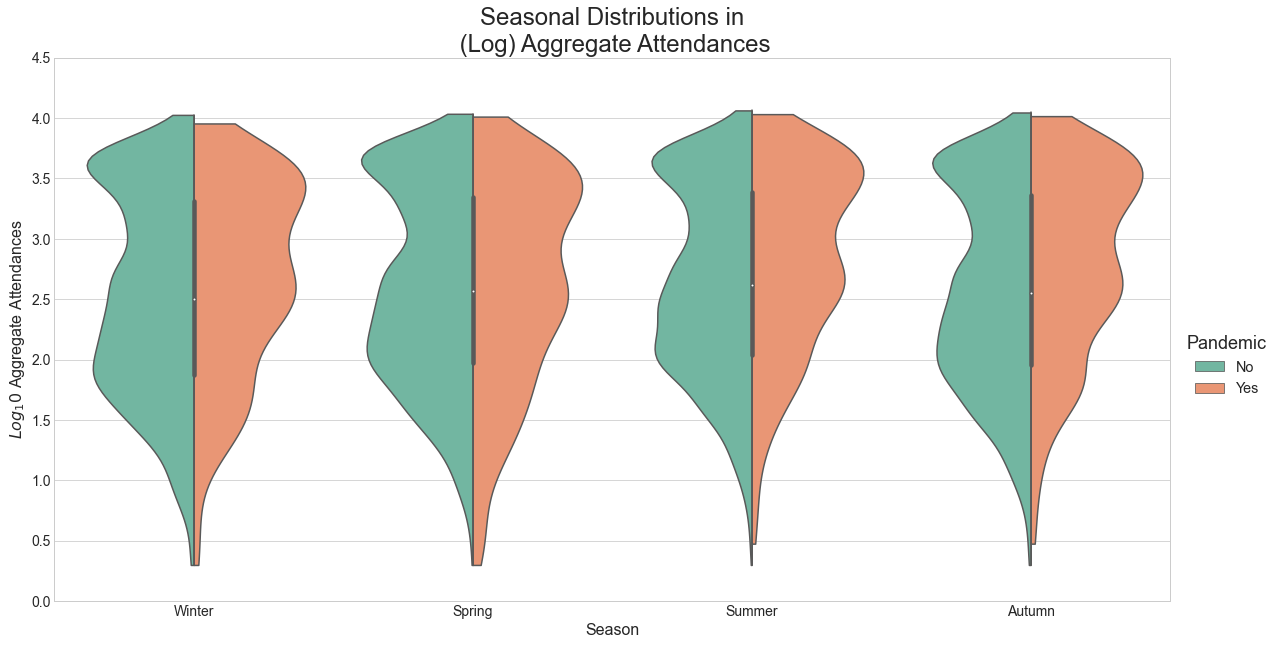

In [39]:
# We use the seaborn package in order to create violin plots
fig, ax = plt.subplots(figsize=(20, 10))

sns.violinplot(x='Season', y='Log_Number_Attendances_agg', hue='pandemic',
              data=data, palette='Set2', cut= 0, split=True, order=['Winter', 'Spring', 'Summer', 'Autumn'])

# Adjust titles, axis labels and tick fontsize
plt.title('Seasonal Distributions in\n (Log) Aggregate Attendances', fontsize=24)
plt.ylabel('$Log_10$ Aggregate Attendances', fontsize=16)
plt.xlabel('Season', fontsize=16)
plt.tick_params(labelsize=14)

# Adjust the legend and set labels manually
plt.legend(title='Pandemic', bbox_to_anchor=(1.01, 0.5), loc=2, borderaxespad=0., fontsize='x-large', title_fontsize='18')

for t, l in zip(ax.get_legend().texts, ['No', 'Yes']):
    t.set_text(l)

# Fix y-axis limits to avoid distortion
plt.ylim(0, 4.5)

plt.savefig("seasondist.png")

plt.show()

From this final plot we make some interesting inferences:

- The distribution of number of attendances between the four different seasons is very similar suggesting that there is some kind of seasonality in our data
- Summer and Autumn distributions seem to be more left-skewed suggesting there are more attendances in these seasons (higher centers)
- The range of the distributions seems to be quite comparable among seasons, suggesting there is the same amount of variability in number of attendances each season
- Prepandemic distribution has two noticeable peaks, whereas pandemic distribution has 3 peaks that are comparatively smaller in size. In other words, there were fewer attendances during covid than before it which would align with our knowledge about lockdown

**NB**: Our investigation into the distribution brought up an interesting fact about the number of attendances meeting the target. For all four seasons, the data seems to be very heavily left-skewed with most centres claiming to adhere to the standard in 100% of attendances. 

This, while not impossible, does bring the validity of our dataset to question as it raises the suspicion that there may be data omitted for the attendances that did not comply with the standard. We believe this is a point worth bringing to the reader's attention.

Finally, we represent the distribution of number of monthly attendances using a similar procedure...

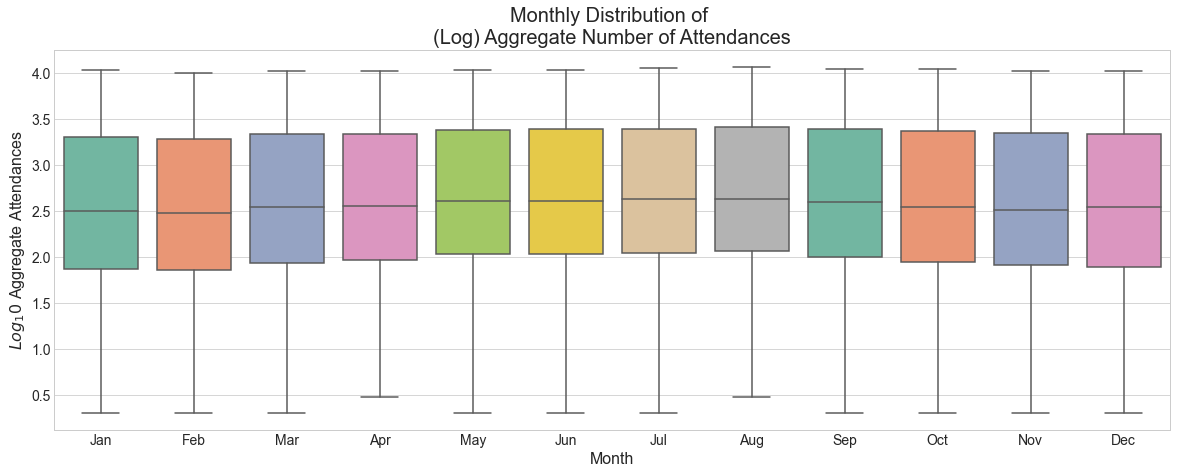

In [27]:
# # We create our figure and axes
fig, axes = plt.subplots(figsize=(20, 7))

# We create the KDE plot
ax = sns.boxplot(x='Month', y='Log_Number_Attendances_agg', data=data, order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], palette='Set2')
ax.set_title('Monthly Distribution of \n(Log) Aggregate Number of Attendances', fontsize=20)
ax.set_ylabel('$Log_10$ Aggregate Attendances', fontsize=16)
ax.set_xlabel('Month', fontsize=16)
ax.tick_params(labelsize=14)

plt.show()

We see there is a general trend whereby autumn and summer months see a perceivable increase in the number of attendances as compared to the rest of the year (same observation as above)

## Part 7 - Miscellaneous Visualizations

A collection of visualizations that illustrate other features and trends about the dataset

**Figure A**: Visualizing the distribution of percentage meeting target before and during the pandemic

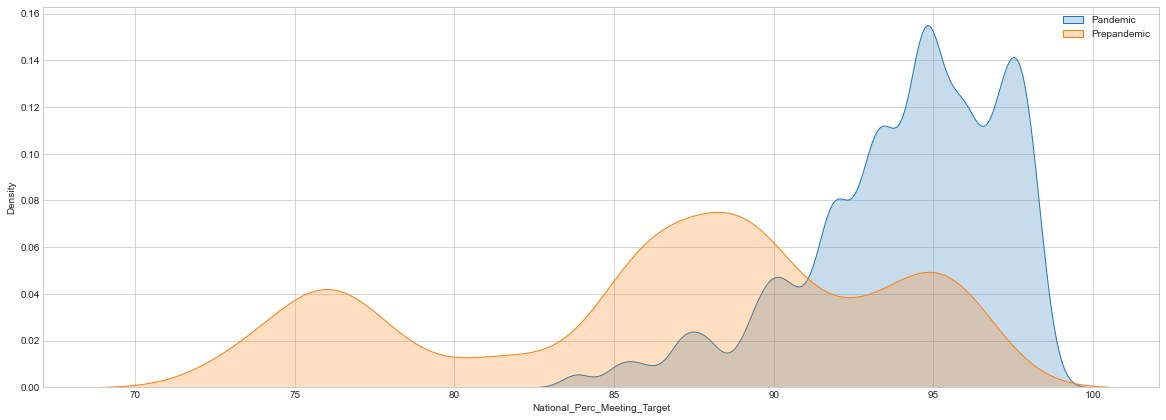

In [28]:
# We start by adding a national rolling percentage statistic for each month in our dataset
monthly_natpercentages = data.groupby('Data_Month_Date').sum()['Number_Meeting_Target_agg'] * 100 / data.groupby('Data_Month_Date').sum()['Number_Of_Attendances_agg']
data['National_Perc_Meeting_Target'] = data['Data_Month_Date'].apply(lambda dat: monthly_natpercentages.loc[dat])

# Since the distributions are heavily skewed, we apply log transformation
data['Log_National_Perc_Meeting_Target']= np.log(data['National_Perc_Meeting_Target'])

# We take the prepandemic and pandemic subsets of our data and visualize their distribution
fig, axes = plt.subplots(figsize=(20, 7))

sns.kdeplot(data=data.iloc[0:data[data['Data_Month_Date'] == '20200301'].index[0]], x='National_Perc_Meeting_Target', fill=True, ax=axes)
sns.kdeplot(data=data.iloc[data[data['Data_Month_Date'] == '20200301'].index[0]:], x='National_Perc_Meeting_Target', fill=True, ax=axes)

plt.legend({'Prepandemic', 'Pandemic'})

plt.show()

**Figure B**: Box plot showing same distribution in figure A

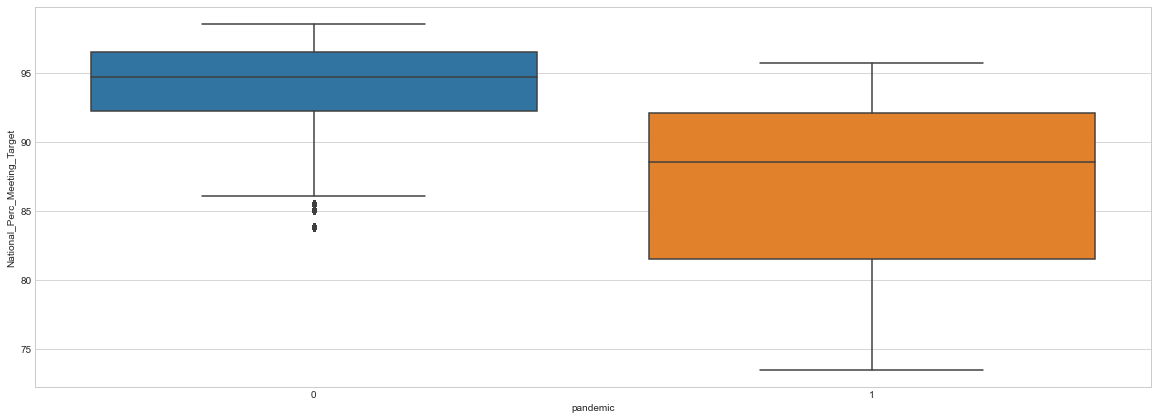

In [29]:
# We plot as boxplot rather than kde plot
fig, axes = plt.subplots(figsize=(20, 7))

sns.boxplot(x='pandemic', y='National_Perc_Meeting_Target', data=data,
            order=[0, 1])

plt.show()

Figure C: Recreation of time series visualization of national percentage in online dashboard

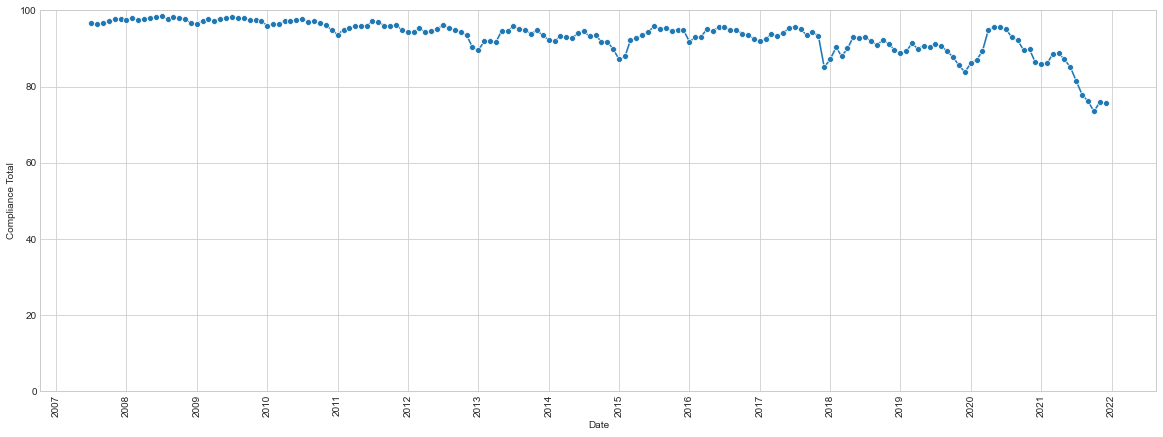

In [30]:
# A simple line plot showing the relationship seen in online dashboard
fig, axes = plt.subplots(figsize=(20, 7))

# We use seaborn package to create line plot and manually set x and y axis labels
graph = sns.lineplot(data=data, x="Data_Month_Date", y='National_Perc_Meeting_Target', marker='o')
graph.set_xlabel("Date")
graph.set_ylabel("Compliance Total")

# We set the major and minor tick locators to graph and add formatted labels
axes.xaxis.set_major_locator(years)
axes.xaxis.set_major_formatter(years_fmt)
axes.xaxis.set_minor_locator(months)

# We rotate the labels vertically for better readability and show the plot
plt.xticks(rotation='vertical')

# Fix y-axis scale to avoid distortion
axes.set_ylim(0, 100)

plt.show()

**Figure D**: Additive Decomposition of Monthly Trend in Number of Attendances Meeting Target

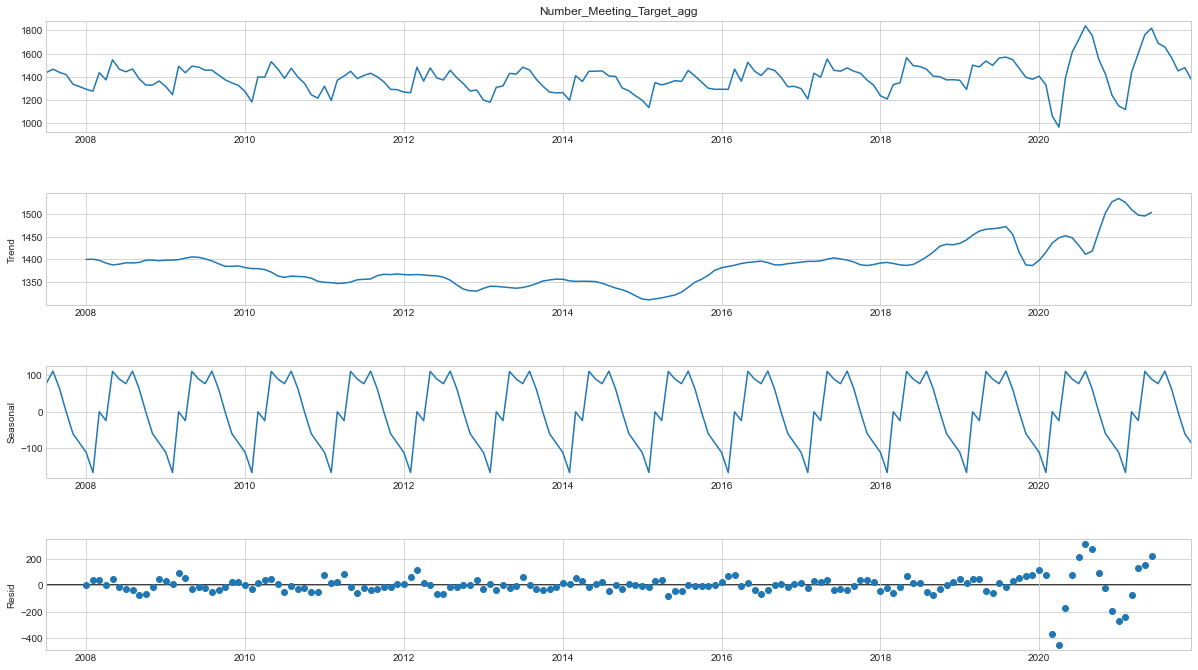

In [31]:
# We use the statsmodels library to decompose our monthly trend in attendances into components
# We check for seasonality by setting a period of 12 months
decomposition = seasonal_decompose(data.groupby('Data_Month_Date').mean()['Number_Meeting_Target_agg'], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)

plt.show()

As we will explore below there is a clear upwards trend in number of attendances meeting the target (indicating more overall attendances after the pandemic), a definite yearly periodicity to the data and higher variability (as seen in residuals) in the data after the pandemic

## Part 8 - Pandemic-Compliance Effect

In this section we will be investigating the change in compliance patterns caused by the pandemic and arriving at a confidence interval indicating whether or not the change is significant. We will be carrying out bootstrap estimation to determine this confidence interval.

More specifically, we outline the process we will carry out in the steps below:

1. We will calculate the difference in distribution mean of percentage meeting target pre and post-pandemic

2. We will randomly sample 20 entries from both pre and post pandemic

3. We will calculate the difference in means between these 2 samples and take this statistic

4. We will repeat this process 1000 times to arrive at a relevant normal distribution of differences in means between samples

5. We will use this distribution to determine significance levels and confidence intervals for our observed difference in mean

We start by specifying our null and alternative hypotheses as follow:

$H_0$: The difference in the average percentage of meetings meeting target before and after the pandemic is negligible ($d_0 = 0$)

$H_a$: The difference in the average percentage of meetings meeting target before and after the pandemic is not negligible ($d_0 > 0$)

First, let's analyse the size of the effect we observe

In [32]:
# Calculate the difference in mean percentage meeting target before and during pandemic
natperc_prepandemic = data[data['pandemic'] == 0]['National_Perc_Meeting_Target']
natperc_pandemic = data[data['pandemic'] == 1]['National_Perc_Meeting_Target']

print(f"The average percentage in attendances meeting 4-hour standard pre-pandemic is {natperc_prepandemic.mean()}")
print(f"The average percentage in attendances meeting 4-hour standard post-pandemic is {natperc_pandemic.mean()}")
print(f"The difference in average percentages is therefore {natperc_prepandemic.mean() - natperc_pandemic.mean()}")

# Include different statistics for both distributions
print("\nOther summary statistics for percentage in attendances meeting 4-hour standard pre-pandemic found below:\n")
print(natperc_prepandemic.describe())

print("\nOther summary statistics for percentage in attendances meeting 4-hour standard post-pandemic found below:\n")
natperc_pandemic.describe()

The average percentage in attendances meeting 4-hour standard pre-pandemic is 94.11713949210457
The average percentage in attendances meeting 4-hour standard post-pandemic is 86.52768615040677
The difference in average percentages is therefore 7.589453341697805

Other summary statistics for percentage in attendances meeting 4-hour standard pre-pandemic found below:

count    14067.000000
mean        94.117139
std          3.075995
min         83.827377
25%         92.224514
50%         94.663409
75%         96.497331
max         98.526587
Name: National_Perc_Meeting_Target, dtype: float64

Other summary statistics for percentage in attendances meeting 4-hour standard post-pandemic found below:



count    1404.000000
mean       86.527686
std         6.770823
min        73.474886
25%        81.524378
50%        88.503502
75%        92.120795
max        95.718509
Name: National_Perc_Meeting_Target, dtype: float64

From the descriptive statistics shown above we can see there is about an 8% decrease in attendances meeting the 4-hour target during the pandemic compared to pre-pandemic times. Additionally, we see there is much more spread in the percentage of complying attendances after the pandemic with lower minimum and maximum values. All of these findings line up with the distributions we observed in Figure A. 

We will now attempt to determine whether this 8% difference is significant or not using bootstrap estimation

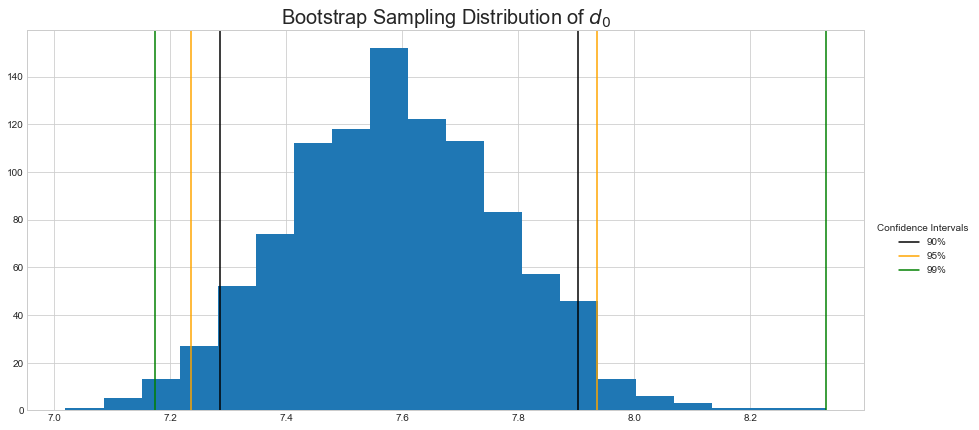

[7.2360565  7.93558226] 0.18621245502374673


In [33]:
def bootstrap(x, y, k=1000, estimator=np.mean, quantiles=[0.025, 0.975], plot=False):
    n_x = len(x)
    n_y = len(y)

    distribution = np.zeros(k)

    for i in range(k):
        x_star = np.random.choice(x, n_x, replace=True)
        y_star = np.random.choice(y, n_y, replace=True)

        distribution[i] = estimator(x_star) - estimator(y_star)

    if plot:
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.hist(distribution, 20)

        ax.set_title('Bootstrap Sampling Distribution of $d_0$', fontsize=20)

        # Calculate and mark confidence intervals
        ci95 = np.quantile(distribution, quantiles)  # 95% CI 
        ci90 = np.quantile(distribution, [0.05, 0.95])  # 90% CI
        ci99 = np.quantile(distribution, [0.01, 1])  # 99% CI

        ax.axvline(ci90[0], color='black')
        ax.axvline(ci90[1], color='black')

        ax.axvline(ci95[0], color='orange')
        ax.axvline(ci95[1], color='orange')

        ax.axvline(ci99[0], color='green')
        ax.axvline(ci99[1], color='green')

        # Fix Legend Manually
        ax.legend(title='Confidence Intervals', bbox_to_anchor=(1.01, 0.5), loc=2, borderaxespad=0., labels=['90%', '95%', '99%'], fancybox=True)
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('orange')
        ax.get_legend().legendHandles[2].set_color('green')

        plt.show()
    
    return (ci95, np.std(distribution), distribution)

ci, std, distribution = bootstrap(data[data['pandemic'] == 0]['National_Perc_Meeting_Target'], 
                                  data[data['pandemic'] == 1]['National_Perc_Meeting_Target'], plot=True)
print(ci, std)

We can now calculate a p-value for an observed difference in means of 0 to determine its statistical significance:

In [34]:
# Determine p-value from bootstrap distribution
num_negligible_diff = ((0 <= distribution) & (distribution <= 0.1)).sum()

p = num_negligible_diff / len(distribution)
print(f"The p-value for the null hypothesis (d_0 = 0) is {p}")

The p-value for the null hypothesis (d_0 = 0) is 0.0


Through bootstrapping we arrive at a 95% confidence interval for the statistic (difference in mean before and after the pandemic) that does not contain 0. Therefore, we can be 95% confident that there is a (non-zero) difference in mean percentage of attendances meeting the 4-hour standard before and after the pandemic. More specifically, we can be sure that this difference corresponds to about a 7% decrease between the 2 periods.

We therefore decide to reject the null hypothesis at p < 0.001 and accepting the alternative hypothesis suggesting there is a statistically significant difference in the average percentage of meetings complying to the standard before and after the pandemic, with a significant decrease in this statistic seen during the pandemic.

## Part 8.5 - Two Sample t-test

As a sanity check, we will also run a 2-sample t-test to reassure us of whether the difference in means before and during the pandemic is significant or not. We set up our hypotheses as follow:

$H_0$: The mean percentage in attendances complying to the 4-hour standard before and after the pandemic are equal ($\mu_{pre} = \mu_{pand}$)

$H_a$: The mean percentage in attendances complying to the 4-hour standard before and after the pandemic are not equal ($\mu_{pre} \ne \mu_{pand}$)

In [35]:
# We must first extract 2 equal sized samples from before and after the pandemic
pre_total = data.query('pandemic == 0')['National_Perc_Meeting_Target']
pand_total = data.query('pandemic == 1')['National_Perc_Meeting_Target']

pre_sample = np.random.choice(pre_total, len(pand_total), replace=False)
pand_sample = pand_total  # We take all of the observations during the pandemic as our sample

stat, p_val = ttest_rel(pre_sample, pand_sample)

print(f"The resulting p-value from our paired two-sample t-test is: {p_val}")

The resulting p-value from our paired two-sample t-test is: 2.071514065323591e-207


Once again, since p < 0.001, we reject the null hypothesis that prepandemic and pandemic mean of percentage of attendances complying to the 4-hour standard are equal and instead accept the alternative hypothesis

## Part 9 - Testing Stationarity of Monthly Trend

It is quite clear from our monthly compliance line plot that the number of compliances over time follows a seasonal trend and is therefore not stationary. However, we would like to apply a statistical test to ensure that this is the case and therefore there is a seasonality or trend in the number of compliances in our data.

For this, we will apply the Augmented Dickey-Fuller Unit Root Test on the mean trend with the following hypotheses:

$H_0$: a unit root is present (average monthly trend in compliance is non-stationary)

$H_a$: a unit root is not present (average monthly trend in compliance is stationary)

In [36]:
orderedMonthlyMeanCompliance = list(data.groupby('Data_Month_Date').mean()['National_Perc_Meeting_Target'])

statistic, p, lags, obs, crit, t = adfuller(orderedMonthlyMeanCompliance)
print('stat=%.3f, p=%.3f' % (statistic, p))
if p > 0.05:
    print("Cannot Reject H_0: Probably not stationary")
else:
    print("Reject H_0: Probably Stationary")

stat=1.265, p=0.996
Cannot Reject H_0: Probably not stationary


Our result confirms our suspicion that the monthly trend is not stationary and therefore exhibits a trend as suggested by the visualization. Since our p-value for the test is greater than 0.05, we cannot reject the null hypothesis $H_0$

## Part 9.5 - Testing for Seasonality in Monthly Trend

Now that we have established there is some kind of trend in our monthly compliance mean, we would like to investigate whether there is seasonality in the time series. If so, as suggested by the line plot, it will allow us to investigate this correlation further through additional inference techniques.

In order to test for seasonality, we will be using the Kruskal-Wallis test, whereby we will compare the median of each monthly samples of our dataset to determine if it varies significantly, thereby implying seasonality. We will test the following hypotheses:

$H_0$: There is no seasonality (all groups have same median)

$H_1$: There is seasonality (median of groups differ significantly between periods)

In [37]:
yearly_samples = [[list(e) for e in s[1:]][0]
                    for s in data.groupby('Year')['National_Perc_Meeting_Target']]

h_stat, p_value = kruskal(*yearly_samples)

print(h_stat, p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: seasonality present")
else:
    print("Accept the null hypothesis: no seasonality")

12410.58890843947 0.0
Reject the null hypothesis: seasonality present


The result of the Kruskal-Wallis test clearly indicates that we can reject the null hypothesis and conclude that there exist a yearly trend in the number of attendances meeting the 4-hour standard.

## Part 10: Investigating Effect of Time of Year on Number Meeting Target

From our visualization of the distribution of attendances meeting the target, we can see there are clearly some variations in the number of complying attendances between seasons. Particularly we noticed that Winter and Autumn seem to have a more right-skewed distribution (implying less attendances meet the 4-hour standard) than Summer and Spring. In order to investigate this further, we will carry out a multiple OLS regression with dummy binary variables encoding each season to determine whether or not there is such a correlation between the time of year and the number meeting target.

We therefore begin by establishing the following hypotheses:

$H_0$: There is no relationship between the time of year (season) and the number of attendances meeting target

$H_a$: There is a significant relationship between the time of year (season) and number of attendances meeting target

We use the following model for our multiple regression:

$\hat{y} = \beta_0 + \beta_1 t + \beta_2 spr + \beta_3 sum + \beta_4 win$

where we use autumn as our reference point and where spr, sum and win represent dummy variables that are 1 if the statistic belongs to the corresponding season and 0 otherwise. 

In [38]:
# Fit OLS model with intercept on dummy predictor variables
# C() syntax creates dummy variables for us
fit = ols('National_Perc_Meeting_Target ~ C(Season)', data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     National_Perc_Meeting_Target   R-squared:                       0.066
Model:                                      OLS   Adj. R-squared:                  0.066
Method:                           Least Squares   F-statistic:                     363.2
Date:                          Sun, 03 Apr 2022   Prob (F-statistic):          5.79e-228
Time:                                  19:39:59   Log-Likelihood:                -43572.
No. Observations:                         15471   AIC:                         8.715e+04
Df Residuals:                             15467   BIC:                         8.718e+04
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              93.4292      0.064   1457.232      0.000      93.304      93.555
C(Season)[T.Spring]     0.3917      0.092      4.254      0.000       0.211       0.572
C(Season)[T.Summer]     1.2804      0.091     14.044      0.000       1.102       1.459
C(Season)[T.Winter]    -1.6808      0.091    -18.379      0.000      -1.860      -1.502
==============================================================================
Omnibus:                     6242.133   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31187.725
Skew:                          -1.914   Prob(JB):                         0.00
Kurtosis:                       8.808   Cond. No.                         4.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can interpret our results as follows:


- The mean number of attendances meeting target in Autumn was 1384

- In Spring, we would expect about 35 more meetings on target than the Autumn baseline on average

- In Summer, we would expect about 90 more on average

- In Winter, we would expect about 114 less meetings on target than in Autumn

- The low p-value (<0.05) means we can reject the null hypothesis and therefore we conclude there is a significant statistical relationship between season and number meeting target

- The low $R^2$ suggests our model does not explain a lot of the variance in number of attendances meeting target. This is consistent with our expectations as seasonal variables are a relevant but insufficient list of the necessary predictor variables for the number of attendances meeting target (other predictors such as discharge destination, number of positive covid cases, etc. would explain more of this variance). 

- The low $R^2$ does not affect the validity of our model as we are not using it to predict number of attendances meeting target from the season. 